In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
import seaborn as sns

### Load and Review Data

In [2]:
# Load CNN/DailyMail data
data_cd = np.load('../data/cnn_dailymail.npz', allow_pickle=True)

X_train_cd = data_cd['X_train'] # Where X is Articles (Documents)
y_train_cd = data_cd['y_train'] # and y is Highlights (Summaries)
X_test_cd = data_cd['X_test']
y_test_cd = data_cd['y_test']
X_val_cd = data_cd['X_val']
y_val_cd = data_cd['y_val']

# Concatenate numpy arrays 
X_cd = np.concatenate([X_train_cd, X_test_cd, X_val_cd]) # All CNN/DailyMail articles
y_cd = np.concatenate([y_train_cd, y_test_cd, y_val_cd]) # All CNN/DailyMail highlights

# Create dataframe 
df_cd = pd.DataFrame(
    {'document': X_cd,
     'summary': y_cd
    })

# Display first few rows
df_cd.head(3)

,document,summary
0,"ATLANTA, Georgia (CNN) -- It's midnight on the...",Atlanta bar owner converts BBQ smoker into rob...
1,"BAGHDAD, Iraq (CNN) -- The remains of two U.S...",NEW: Remains found of two U.S. contractors who...
2,WASHINGTON (CNN) -- Sniper Lee Boyd Malvo said...,Social worker says sniper Lee Boyd Malvo is a ...


In [3]:
# Load NewsAPI web-scraped data
data_ws = np.load('../data/news_api_data.npz', allow_pickle=True)

# Initialize splits
X_train_ws = data_ws['X_train'] # Documents
y_train_ws = data_ws['y_train'] # Summaries
X_test_ws = data_ws['X_test']
y_test_ws = data_ws['y_test']
X_val_ws = data_ws['X_val']
y_val_ws = data_ws['y_val']

# Concatenate numpy arrays 
X_ws = np.concatenate([X_train_ws, X_test_ws, X_val_ws]) 
y_ws = np.concatenate([y_train_ws, y_test_ws, y_val_ws]) 

# Create dataframe 
df_ws = pd.DataFrame(
    {'document': X_ws,
     'summary': y_ws
    })

# Display first few rows
df_ws.head(3)

,document,summary
0,"Manchester United manager Erik ten Hag, speaki...",Listen to BBC radio commentary & follow live t...
1,Last updated on .From the section European Foo...,Inter Milan seal their 20th Italian title by b...
2,The Rwanda asylum scheme certainly doesn’t get...,The prime minister has vowed to keep the Commo...


In [4]:
# Make combined dataframe with both CNN/DailyMail and Web-scraped data
combined_df = pd.concat([df_cd, df_ws], ignore_index=True)
combined_df.head(3)

,document,summary
0,"ATLANTA, Georgia (CNN) -- It's midnight on the...",Atlanta bar owner converts BBQ smoker into rob...
1,"BAGHDAD, Iraq (CNN) -- The remains of two U.S...",NEW: Remains found of two U.S. contractors who...
2,WASHINGTON (CNN) -- Sniper Lee Boyd Malvo said...,Social worker says sniper Lee Boyd Malvo is a ...


In [5]:
# Check shape of both dataframes
print(df_cd.shape, df_ws.shape, combined_df.shape)

(1000, 2) (37, 2) (1037, 2)


In [10]:
# Check for null values
print('CNN/DailyMail null values:')
print(df_cd.isnull().mean().sort_values(ascending=False))
print('\nWebAPI null values:')
print(df_ws.isnull().mean().sort_values(ascending=False))

CNN/DailyMail null values:
document    0.0
summary     0.0
dtype: float64

WebAPI null values:
document    0.0
summary     0.0
dtype: float64


In [12]:
# Check size, variables, & dtypes
print('CNN/DailyMail info:\n')
df_cd.info(memory_usage='deep')
print('\nWebAPI info:\n')
df_ws.info(memory_usage='deep')

CNN/DailyMail info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   document  1000 non-null   object
 1   summary   1000 non-null   object
dtypes: object(2)
memory usage: 3.8 MB

WebAPI info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37 entries, 0 to 36
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   document  37 non-null     object
 1   summary   37 non-null     object
dtypes: object(2)
memory usage: 183.3 KB


### Text-Specific Analysis

In [13]:
# Create new columns 'doc_length' and 'sum_length'

# Document length
combined_df['words'] = combined_df['document'].str.split()
combined_df['doc_length'] = combined_df['words'].str.len()
combined_df = combined_df.drop(columns=['words'])

# Summary length
combined_df['words'] = combined_df['summary'].str.split()
combined_df['sum_length'] = combined_df['words'].str.len()
combined_df = combined_df.drop(columns=['words'])

# Check new columns added 
combined_df.head(3)

,document,summary,doc_length,sum_length
0,"ATLANTA, Georgia (CNN) -- It's midnight on the...",Atlanta bar owner converts BBQ smoker into rob...,822,38
1,"BAGHDAD, Iraq (CNN) -- The remains of two U.S...",NEW: Remains found of two U.S. contractors who...,845,52
2,WASHINGTON (CNN) -- Sniper Lee Boyd Malvo said...,Social worker says sniper Lee Boyd Malvo is a ...,652,36


In [14]:
# Summary statistics for document and summary length
combined_df.describe(exclude=['O'])

,doc_length,sum_length
count,1037.000000,1037.000000
mean,588.103182,41.989392
std,298.583891,8.485218
min,50.000000,12.000000
25%,353.000000,36.000000
50%,538.000000,43.000000
75%,779.000000,49.000000
max,2845.000000,66.000000


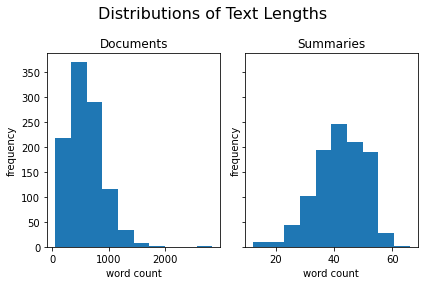

In [25]:
# Plot histograms of document & summary length
dist1 = combined_df['doc_length']
dist2 = combined_df['sum_length']

# Subplot for displaying 2 histograms
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, tight_layout=True);

ax1.hist(dist1)
ax1.set_title('Documents')
ax1.set_xlabel('word count')
ax1.set_ylabel('frequency')

ax2.hist(dist2)
ax2.set_title('Summaries')
ax2.set_xlabel('word count')
ax2.set_ylabel('frequency')

fig.suptitle('Distributions of Text Lengths', fontsize=16);

In [26]:
# Text frequency analysis (excluding stopwords)
stop_words = stopwords.words("english")

In [27]:
# Define funtion for word frequency
def analyze_word_frequency(text_data):

  words = [word.lower() for word in text_data.split() if word not in stop_words]

  from collections import Counter

  word_counts = Counter(words)

  most_frequent_words = word_counts.most_common(10)  # Top 10 most frequent words

  return most_frequent_words

In [28]:
# Analyze word frequency in documents and summaries
document_word_freqs = analyze_word_frequency(" ".join(combined_df["document"]))
summary_word_freqs = analyze_word_frequency(" ".join(combined_df["summary"]))

In [29]:
print("Top 10 most frequent words (excluding stopwords) in documents:")
print(document_word_freqs)
print("Top 10 most frequent words (excluding stopwords) in summaries:")
print(summary_word_freqs)

Top 10 most frequent words (excluding stopwords) in documents:
[('the', 4131), ('said', 3719), ('--', 3071), ('said.', 2538), ('i', 2183), ('.', 2025), ('one', 1256), ('would', 1140), ('people', 1094), ('also', 1081)]
Top 10 most frequent words (excluding stopwords) in summaries:
[('.', 3340), ('says', 451), ('new:', 217), ('the', 173), ('u.s.', 167), ('say', 146), ('police', 108), ('two', 99), ('president', 98), ('people', 95)]


### Visualize Data Insights

Number of document outliers: 10
Number of summary outliers: 8


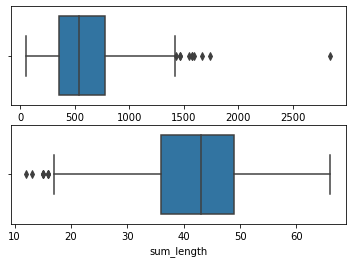

In [34]:
# Calculate IQR for documents
doc_Q1 = combined_df['doc_length'].quantile(0.25)
doc_Q3 = combined_df['doc_length'].quantile(0.75)
doc_IQR = doc_Q3 - doc_Q1

# Calculate IQR for summaries
sum_Q1 = combined_df['sum_length'].quantile(0.25)
sum_Q3 = combined_df['sum_length'].quantile(0.75)
sum_IQR = sum_Q3 - sum_Q1

# Get bounds for determining outliers
doc_lb = doc_Q1 - 1.5 * doc_IQR
doc_ub = doc_Q3 + 1.5 * doc_IQR
sum_lb = sum_Q1 - 1.5 * sum_IQR
sum_ub = sum_Q3 + 1.5 * sum_IQR

# Identify outliers
doc_outliers = combined_df[(combined_df['doc_length'] < doc_lb) | (combined_df['doc_length'] > doc_ub)]
sum_outliers = combined_df[(combined_df['sum_length'] < sum_lb) | (combined_df['sum_length'] > sum_ub)]

print(f"Number of document outliers: {len(doc_outliers)}")
print(f"Number of summary outliers: {len(sum_outliers)}")

# Define dimensions of subplots (rows, columns)
fig, axes = plt.subplots(2, 1)

# Boxplots for subplot
sns.boxplot(data=combined_df, x='doc_length', ax=axes[0]);
sns.boxplot(data=combined_df, x='sum_length', ax=axes[1]);

In [36]:
# Outlier rows by document length
doc_outliers

,document,summary,doc_length,sum_length
30,(CNN) -- CNN.com reader Kristy O'Connor took a...,I-Reporters share tales of meeting Heath Ledge...,1743,36
150,(Mental Floss) -- There have been presidential...,President Harding's illegitimate daughter was ...,1577,43
288,"CNN Student News -- June 29, 2007 . Transcript...",Get a glimpse at the next generation of gadget...,1464,28
320,"LONDON, England (CNN) -- Prince Harry led trib...","Prince Harry describes Princess Diana as ""the ...",1665,43
321,"If you're like us, you eat out more than ever ...",Health magazine names Top 10 chain restaurants...,1551,39
355,"BAGHDAD, Iraq (CNN) -- Four U.S. soldiers die...","NEW: As Iraq war enters sixth year, American d...",1427,56
791,(CNN Student News) -- Record the CNN Special I...,Learn about autism spectrum disorders (ASD)\nE...,1589,26
880,(InStyle.com) -- We asked five stars for their...,Perfumes trigger strong memories for stars .\n...,1469,26
1007,Editor’s Note: Sign up to get this weekly colu...,After two months of inaction partly induced by...,2845,24
1016,"On April 19, 1824, Lord Byron died at Missolon...","On the 200th anniversary of his death, two new...",1574,28


In [37]:
# Outlier rows by summary length
sum_outliers

,document,summary,doc_length,sum_length
1004,"After months of delay, the House of Representa...",World leaders have been repeating calls for de...,135,15
1006,Red Bull team principal Christian Horner told ...,Follow live text and BBC Radio 5 Sports Extra ...,161,15
1014,Donald Trump has just returned to the courtroo...,Lawyers will outline their cases in front of j...,114,16
1015,A premature baby was saved when doctors perfor...,The infant's entire immediate family died in I...,113,15
1017,Eve O. Schaub is the author of “Year of No Gar...,"It might seem counterintuitive, but plastic as...",882,12
1026,Manchester's Brendan Loughnane returned to win...,Manchester fighter Brendan Loughnane opens his...,180,16
1031,Britain's Kerenza Bryson won gold in the women...,Britain's Kerenza Bryson wins gold at the Pent...,119,13
1034,They stretched their lead eight minutes into t...,Matty Nicholson's late try helps Warrington co...,446,16


In [40]:
# Filter outliers
updated_df = combined_df[(combined_df["doc_length"] > doc_lb) & (combined_df['doc_length'] < doc_ub)]
updated_df = updated_df[(updated_df["sum_length"] > sum_lb) & (updated_df['sum_length'] < doc_ub)]
updated_df.shape

(1019, 4)